載入模型所必須要的相依套件

In [11]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
from transformers import BertModel, BertTokenizer
import sklearn.metrics as metrics

定義參數

In [12]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 160

inferance模型主體

In [16]:
class SentimentRegressor(nn.Module):
    """
    BERT電影影評評分迴歸模型的主體
    Bert sentiment regression model for review sentiment analyzer
    """
    def __init__(self):
        super(SentimentRegressor, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    def load_model(self, path):
        """
        載入先前訓練好的權重檔
        """
        self.load_state_dict(torch.load(path, map_location=DEVICE))

    def predicts(self, text):
        """
        主要的迴歸器，將input電影評論輸入模型，將輸出轉化為預測評分
        make prediction according to the text with the given model
        """
        encoding = TOKENIZER.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        _, output = self.bert(
           input_ids=encoding["input_ids"],
            attention_mask=encoding["attention_mask"]
        )
        return float(self.out(output))

讀取先前由data_extract.py所處理完的資料，去test.json前後各200比做為測試資料

In [19]:
VAL = pd.read_json("./data/test.json")
TEST = list(VAL.comment)[:200] + list(VAL.comment)[-200:]
TRUE = list(VAL.score)[:200] + list(VAL.score)[-200:]
TRUE = list(VAL.score)[:200] + list(VAL.score)[-200:]

預測測試資料

In [ ]:
MODEL = SentimentRegressor()
MODEL.load_model("./regression_model/best_model_state.bin")
prob, predict = MODEL.predicts(TEST[1].replace("<br />", " "))
print(prob)
data = []
for test in tqdm(TEST):
    predict = MODEL.predicts(test.replace("<br />", " "))
    data.append(round(predict))

計算accuracy與r square

In [5]:
print(metrics.accuracy_score(TRUE, data))
print(metrics.r2_score(TRUE, data))

0.3125
0.7420466694209711


產生混淆矩陣

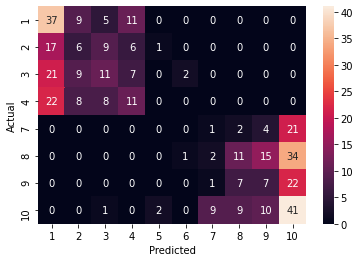

In [6]:
RESULT = pd.DataFrame({"True": TRUE, "Predict": data})
confusion_matrix = pd.crosstab(RESULT["True"], RESULT["Predict"], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()